# PEM Injection 解析 (Coupling Function Analysis) チュートリアル

このノートブックでは `gwexpy` の `CouplingFunctionAnalysis` を使用して、物理環境モニタリング (PEM) インジェクション試験の解析を行う方法を示します。

## 目的
PEM インジェクション試験では、センサー（Witness）から干渉計（Target）への物理的なノイズ結合関数（Coupling Function, CF）を推定します。
CF は以下の式で定義されます：
$$CF(f) = \sqrt{\frac{P_{\text{target, inj}}(f) - P_{\text{target, bkg}}(f)}{P_{\text{witness, inj}}(f) - P_{\text{witness, bkg}}(f)}}$$
$$ \sqrt{P}_{\text{target, projection}}(f) = CF(f) \cdot \sqrt{P}_{\text{witness, bkg}}(f)$$
ここで $P$ は各状態におけるパワースペクトル密度 (PSD) です。

Injection による有意な超過が Target チャンネルで見られない場合は、上限値を与えます。
$$CF_{\text{UL}}(f) = \sqrt{\frac{P_{\text{target, threshold}}(f) - P_{\text{target, bkg}}(f)}{P_{\text{witness, inj}}(f) - P_{\text{witness, bkg}}(f)}}$$
$$ \sqrt{P}_{\text{target, UL}}(f) = CF_{\text{UL}}(f) \cdot \sqrt{P}_{\text{witness, bkg}}(f)$$

この解析により、環境ノイズがどの程度主信号に影響を与えるかを定量化し、ノイズバジェットの策定に役立てることができます。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u

from gwexpy.analysis import PercentileThreshold, SigmaThreshold, estimate_coupling
from gwexpy.noise.asd import from_pygwinc
from gwexpy.noise.wave import from_asd
from gwexpy.plot import Plot
from gwexpy.timeseries import TimeSeries, TimeSeriesDict

# グラフのスタイル設定
plt.rcParams["figure.figsize"] = (10, 6)

## 1. 擬似データの生成

バックグラウンド状態と、特定の周波数帯でノイズを注入したインジェクション状態のデータをシミュレーションします。

- **Witness**: センサー（例：マイク、加速度計、電位）
- **Target**: 干渉計メイン信号（例：Strain）
- **Coupling**: Witness から Target への結合

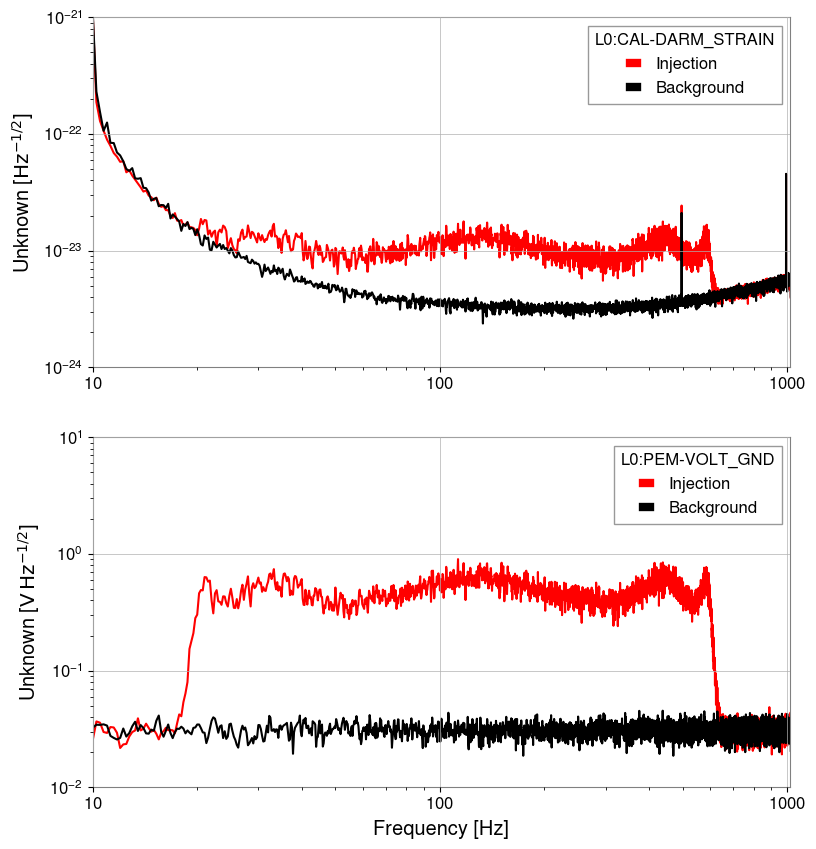

In [2]:
fs = 2048  # サンプリング周波数 [Hz]
duration = 32  # 期間 [s]
t = np.linspace(0, duration, duration * fs, endpoint=False)


# aLIGO の感度曲線(ASD)を取得してターゲットノイズの形状に使う
fmax = fs / 2
asd_target = from_pygwinc(
    "aLIGO", fmin=3.0, fmax=fmax, df=1.0 / duration, quantity="strain"
)
asd_target.name = "L0:CAL-DARM_STRAIN"

wit_name = "L0:PEM-VOLT_GND"
wit_bkg = TimeSeries(
    np.random.normal(0, 1.0, len(t)), t0=0, sample_rate=fs, unit=u.V, name=wit_name
)
wit_inj = TimeSeries(
    np.random.normal(0, 1.0, len(t)),
    t0=duration,
    sample_rate=fs,
    unit=u.V,
    name=wit_name,
)
wit_inj += TimeSeries(
    np.random.normal(0, 20, len(t)),
    t0=duration,
    sample_rate=fs,
    unit=u.V,
    name=wit_name,
).bandpass(20, 600)


cf_true = 2e-23 * asd_target.unit * u.Hz**0.5 / wit_bkg.unit

data_bkg = TimeSeriesDict(
    {
        asd_target.name: from_asd(asd_target, duration, fs, t0=0).highpass(6).notch(8)
        + cf_true * wit_bkg,
        wit_bkg.name: wit_bkg,
    }
)
data_inj = TimeSeriesDict(
    {
        asd_target.name: from_asd(asd_target, duration, fs, t0=duration)
        .highpass(6)
        .notch(8)
        + cf_true * wit_inj,
        wit_inj.name: wit_inj,
    }
)

fftlen = 4.0
plot = Plot(
    data_inj.asd(fftlen, fftlen / 2, method="welch", detrend="linear"),
    separate=True,
    sharex=True,
    color="red",
)
axes = plot.get_axes()
axes[0].set_xlim(10, 1020)
axes[0].set_ylim(1e-24, 1e-21)
axes[1].set_ylim(1e-2, 1e1)
for ax, ch in zip(axes, data_bkg.keys()):
    ax.plot(data_bkg[ch].asd(fftlen, fftlen / 2, method="welch"), color="black")
    ax.legend(["Injection", "Background"], title=ch)

## 2. 結合関数の推定 (基本)

`estimate_coupling` 関数を使用して、インジェクションデータとバックグラウンドデータから結合関数を計算します。
デフォルトでは `RatioThreshold()` が使用され、バックグラウンドに対して Witness の PSD が 25倍以上、Target の PSD が 4倍以上の場所のみを有効なデータとして扱います。

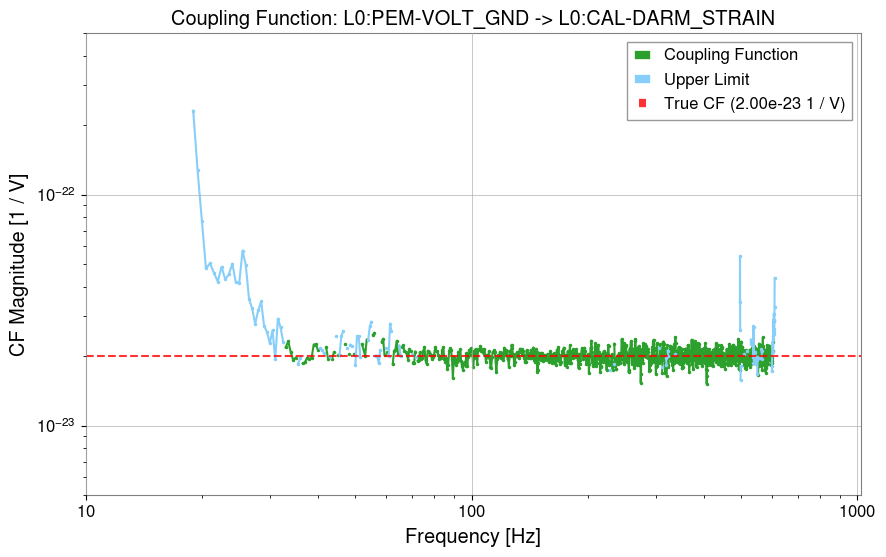

In [3]:
# 結合関数の推定
result = estimate_coupling(
    data_inj,
    data_bkg,
    fftlength=2.0,
    witness=wit_name,
)

# 推定された CF のプロット
result.plot_cf()
plt.axhline(
    cf_true.value,
    color="red",
    linestyle="--",
    alpha=0.8,
    label=f"True CF ({cf_true:.2e})",
)
plt.ylim(5e-24, 5e-22)
plt.xlim(10, 1020)
plt.legend()

## 3. 診断プロット

`plot()` メソッドを使用すると、Witness の PSD、Target の PSD、および結果の CF を一度に確認できます。
インジェクションによってどの程度 PSD が上昇したか（しきい値を超えたか）を視覚的に確認するのに便利です。

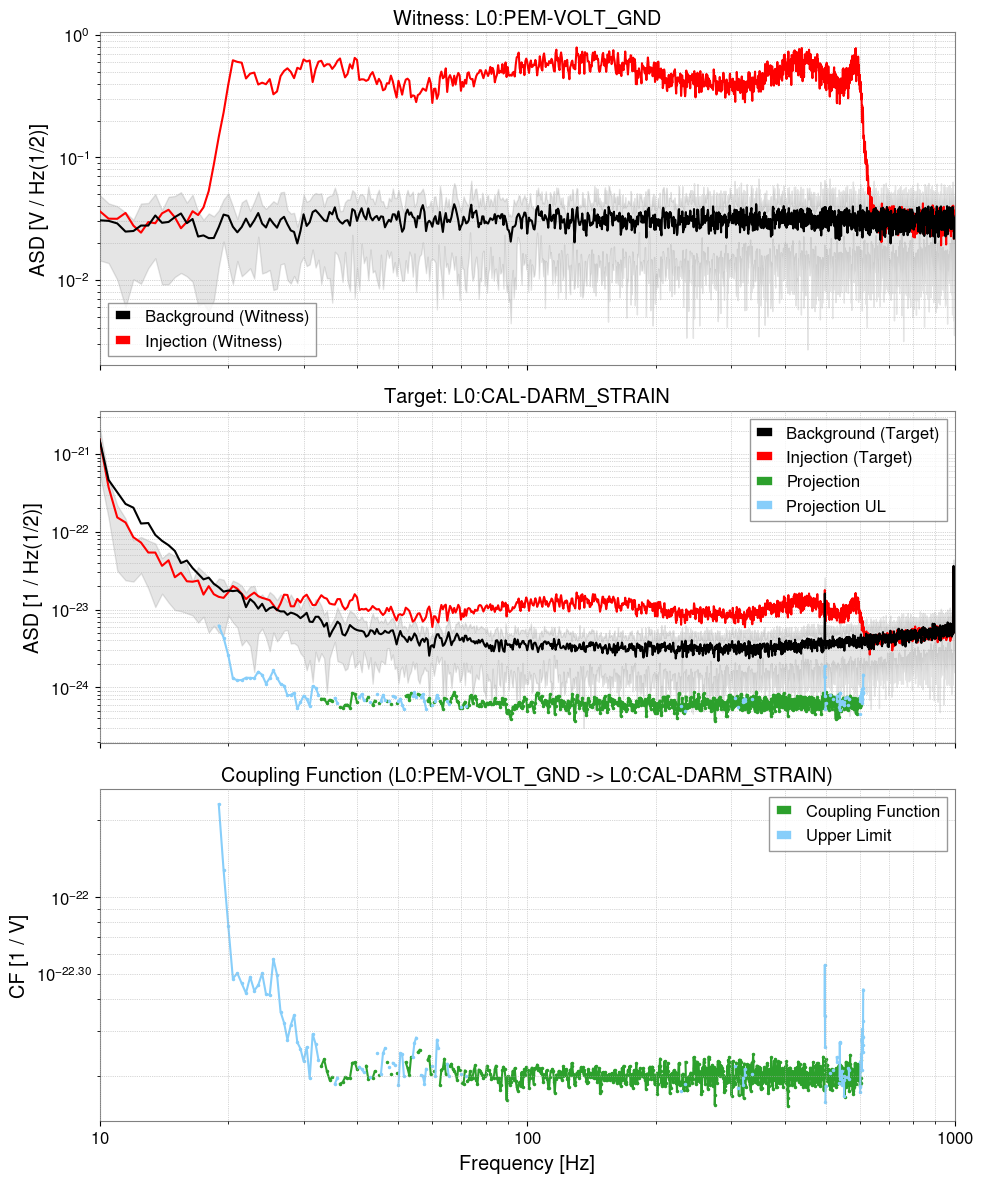

In [4]:
result.plot(xlim=(10, 1000))
plt.show()

## 4. 高度なしきい値戦略

`gwexpy` では、インジェクションを検出するための戦略を柔軟に変更できます。

### SigmaThreshold
統計的な有意性（Gaussian noise を仮定）に基づき、「平均 + N * 標準誤差」を越えるものを検出します。

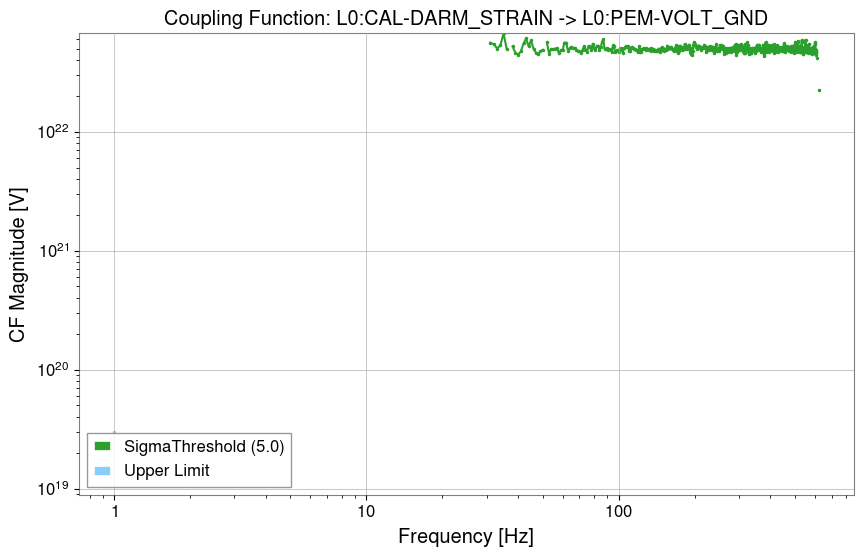

In [5]:
strategy_sigma = SigmaThreshold(sigma=5.0)

result_sigma = estimate_coupling(
    data_inj, data_bkg, fftlength=1.0, threshold_witness=strategy_sigma
)

result_sigma.plot_cf(label="SigmaThreshold (5.0)")
plt.legend()

### PercentileThreshold
バックグラウンドデータの分布（パーセンタイル）に基づきます。非ガウス的なノイズ（グリッチなど）が含まれる場合に、より頑健な検出が可能です。

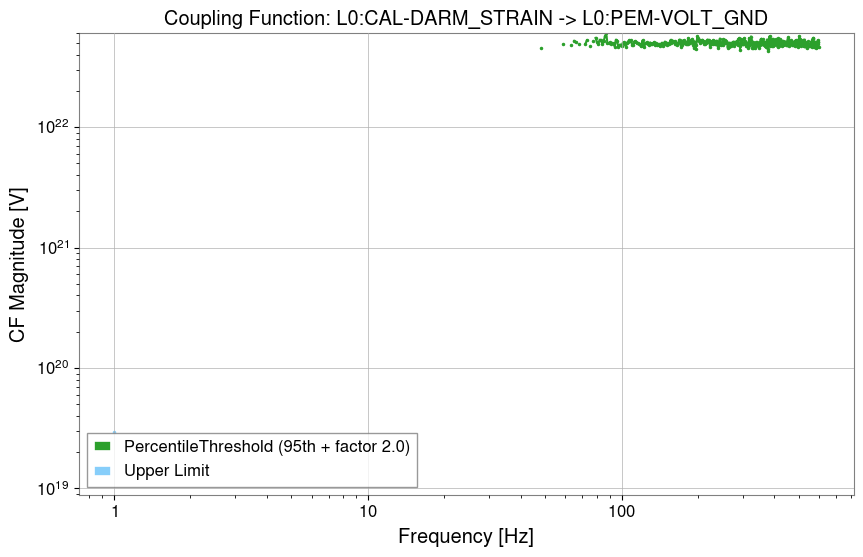

In [6]:
strategy_pct = PercentileThreshold(percentile=95, factor=2.0)

result_pct = estimate_coupling(
    data_inj, data_bkg, fftlength=1.0, threshold_witness=strategy_pct
)

result_pct.plot_cf(label="PercentileThreshold (95th + factor 2.0)")
plt.legend()

## まとめ

`CouplingFunctionAnalysis` (および `estimate_coupling`) を使用することで、手動で PSD の差分や平方根を計算することなく、直感的にインジェクション解析を行うことができます。
特に、`ThresholdStrategy` を使い分けることで、ノイズ環境に応じた適切な結合推定が可能です。